## Rovinná příhradová konstrukce

Ukážeme si základní strukturu programu pro řešení příhradové konstrukce. Příhradová konstrukce je složena z prutů namáhaných tahem/tlakem, které jsou kloubově pospojovány. V každém uzlu uvažujeme dva stupně volnosti - posun ve vodorovném směru a posun ve svislém směru. 

Číslování uzlů je znázorněno na obrázku, v hranatých závorkách jsou uvedena kódová čísla (číslování neznámých). Tuhost prutů $EA = 10^6$ kN. 

 <img src="figures/prihradovina.png" width = 650>

#### Pole souřadnic

Souřadnice jednotlivých uzlů uložíme do matice <code>xy</code>, první sloupec odpovídá souřadnicím x, druhý sloupec souřednicím y. Za účelem procvičení vygenerujeme pole souřadnic s využitím for cyklu. 

In [7]:
% pocet elementu ve smeru x/y
ex = 4; ey = 1;

% delka elementu ve smeru x/y
lx = 4; ly = 3;

xy = []; % prazdna matice
for i = 0:ey
    for j = 0:ex
        coords = [j*lx, i*ly];

        % pridani souradnic uzlu na novy radek matice xy
        xy = [xy; coords];
    end
end

xy

xy =

    0    0
    4    0
    8    0
   12    0
   16    0
    0    3
    4    3
    8    3
   12    3
   16    3



#### Lokalizační matice
Nejdříve si vytvoříme matici, kam uložíme čísla uzlů pro jednotlivé pruty.

In [8]:
elems = [1 2;
         2 3;
         3 4;
         4 5;
         1 6;
         2 6;
         2 7;
         3 7;
         3 8;
         4 8;
         4 9;
         5 9;
         5 10;
         6 7;
         7 8;
         8 9;
         9 10];

Řádky lokalizační matice obsahují kódová čísla odpovídající jednotlivým elementům. Tuto matici si můžeme vygenerovat z matice <code>elems</code>.

In [14]:
nelem = size(elems, 1);  % pocet prvku
lm = zeros(nelem, 4); 
for i = 1:nelem
    lm(i,:) = [elems(i,1)*2-1, elems(i,1)*2, elems(i,2)*2-1, elems(i,2)*2];
end
lm

lm =

    1    2    3    4
    3    4    5    6
    5    6    7    8
    7    8    9   10
    1    2   11   12
    3    4   11   12
    3    4   13   14
    5    6   13   14
    5    6   15   16
    7    8   15   16
    7    8   17   18
    9   10   17   18
    9   10   19   20
   11   12   13   14
   13   14   15   16
   15   16   17   18
   17   18   19   20



#### Matice tuhosti 


Matice tuhosti $K$ zprostředkovává vztah mezi globálnı́mi koncovými silami $f$ a posuny $u$

$
Ku = f.
$

Matice tuhosti pro tažený-tlačený prut v rovině má tvar

$
{K}={{EA}\over{l}}\left[\begin{array}{cccc}
c^2&cs&-c^2&-cs\\
cs&s^2&-cs& -s^2\\
-c^2&-cs&c^2&cs\\
-cs&-s^2&cs&s^2
\end{array}\right],\quad\;\;\begin{array}{c}c=\cos(\phi^e)\\s=\sin(\phi^e)\end{array},
$

kde $l$ je délka prvku a příslušné siny a cosiny napočítáme ze souřadnic uzlů prvku

$
c = \frac{x_2 - x_1}{l}\\
s = \frac{y_2 - y_1}{l}.
$

Odvození matice tuhosti pro tažený-tlačený prut v rovině si ukážeme v některém z navazujících cvičení. 

Protože budeme potřebovat sestavit matici tuhosti pro každý ze 17 prvků, je vhodné vytvořit si pro její výpočet funkci. Takovou funkci potom budeme moci v našem programu volat opakovaně. Vstupními parametry takové funkce budou tuhost <code>EA</code> a souřadnice uzlů prvku <code>locxy</code>.


In [10]:
% funkce pocita matici tuhosti tazeneho-tlaceneho prutu ve 2d
% In: 
%   locxy - vektor souradnic uzlu prvku [x1, y1; x2, y2]
%   EA- soucin modulu pruznosti a plochy
%
% Out:
%   ke - matice tuhosti prvku (4,4)
%
function ke = stiffnessMatrix (locxy,EA) 

length=sqrt((locxy(2,1)-locxy(1,1))^2+(locxy(2,2)-locxy(1,2))^2);
c = (locxy(2,1)-locxy(1,1))/length; c2=c^2;
s = (locxy(2,2)-locxy(1,2))/length; s2=s^2;

ke=(EA/length)*[c2 c*s -c2 -c*s;
                c*s s2 -c*s -s2;
                -c2 -c*s c2 c*s;
                -c*s -s2 c*s s2];
end

#### Řešení

In [16]:
EA =1.e6;

% kodova cisla zatizenych stupnu volnosti
lf = [12, 14, 16, 18, 20];
% velikost sil
F = -5;

% kodova cisla podeprenych stupnu volnosti
up = [1, 2, 9, 10];

% pocet prvku
nelem=size(lm, 1);  % number of rows in lm matrix

% pocet stupnu volnosti
ndof = 2 * size(xy, 1); % two degrees of freedom in each node

% nulovani vektoru zatizeni, matice tuhosti
f=zeros(ndof,1);
k=zeros(ndof);
r=zeros(ndof,1);

% sestaveni matic tuhosti
for i = 1:nelem
    ke = stiffnessMatrix([xy(elems(i,1), :); xy(elems(i,2),:)], EA);
    % lokalizace
    k(lm(i,:), lm(i,:)) += ke;    
    % !: operator += funguje pouze v Octave, v Matlabu pouzijte: k = k + ke
end

% vektor zatizeni
f(lf)=F;

% reseni posunuti
kuu=k;
kuu(up,:) = [];
kuu(:,up) = [];
fu=f;
fu(up) = [];

u=kuu\fu;

% rekonstrukce celeho vektoru posunuti
lm_r = 1:ndof;
lm_r(up) = [];
r = zeros(ndof, 1);

r(lm_r) = u

r =

   0.0000e+00
   0.0000e+00
  -3.3333e-05
  -2.3778e-04
  -2.6667e-05
  -3.2889e-04
  -6.6667e-06
  -2.3778e-04
   0.0000e+00
   0.0000e+00
   3.8750e-05
  -3.7500e-05
  -1.2500e-06
  -2.6028e-04
  -5.4583e-05
  -3.3639e-04
  -9.4583e-05
  -2.3028e-04
  -9.4583e-05
  -1.5000e-05



#### Vykreslení deformovaného tvaru konstrukce

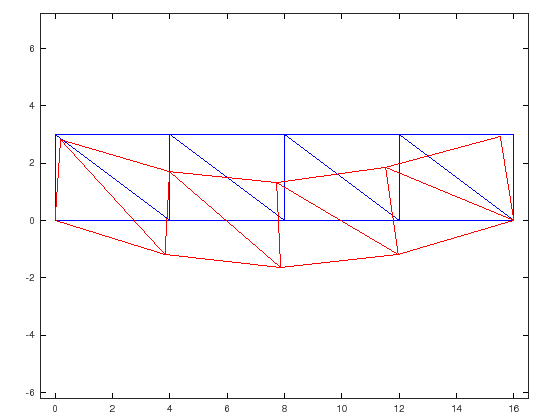

In [18]:
scale = 5e3;

for i = 1:nelem
    % puvodni tvar konstrukce
    x = [xy(elems(i,1), 1); xy(elems(i,2), 1)];
    y = [xy(elems(i,1), 2); xy(elems(i,2), 2)];
    plot(x, y, 'b'); hold on;

    % deformovany tvar konstrukce
    ry  = r(lm(i,[2,4])) * scale;
    rx  = r(lm(i,[1,3])) * scale;
    plot(x+rx, y+ry, 'r'); hold on;
end
axis equal; axis([-0.5 16.5])
    

<div class="alert alert-block alert-info">
### Příklad k procvičení

Zkuste si sami vytvořit podobný program pro řešení jednoduché příhradoviny dle obrázku.


<img src="figures/du_prihradovina.png" width="400">

##### Nápověda
<i>
Můžete převzít strukturu ukázaného programu, navíc můžete použít již vytvořené funkce (stiffnessMatrix). Vyjděte z ukázaného kódu v sekci "Řešení", na jeho začátek doplňte souřadnice uzlů a lokalizační matici, dále upravte inforace o okrajových podmínkách. Uvidíte, že zbytek programu může zůstat prakticky beze změny (pozor na vytvoření vektoru zatížení - rozdílné hodnoty sil).
</i>


</div>
<font color="white">
c

<\font>

In [1]:
% zde doplnte Vas program